# Outlook

In this notebook, using BBRL, you will study the effect of partial observability 
on the CartPoleContinuous-v1 environment, using either the DDPG or the TD3 algorithm.

To emulate partial observability, you will design dedicated wrappers. Then you will study
whether extending the input of the agent policy and critic with a memory of previous states
and its output with action chunks can help solve the partial observability issue. This will
also be achieved by designing other temporal extension wrappers.

**Students:**
<pre>
VU Anh Thu            
LE Thi Minh Nguyet    
</pre>

# Installation

In [1]:
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=False)

import os
import copy
import numpy as np
import gymnasium as gym
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from omegaconf import OmegaConf

/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
error: XDG_RUNTIME_DIR is invalid or not set in the environment.


In [2]:
# Additional packages
from gymnasium import spaces # For creating action and observation spaces
from torch.distributions import Normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Temporal modification wrappers

The CartPoleContinuous-v1 environment is a custom extension of 
[the CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/) 
with continuous actions, between -1 and 1. It is defined in the bbrl_gymnasium library.

As in CartPole, the state of the system contains 4 variables:
- the position $x$,
- the velocity $\dot{x}$,
- the angle of the pole $\theta$,
- the angular velocity $\dot{\theta}$.

To emulate partial observability in CartPoleContinuous-v1, you will hide the $\dot{x}$ and $\dot{\theta}$ features, 
by filtering them out of the state of the environment. This is implemented with the ```FeatureFilterWrapper```.

To compensate for partial observability, you will extend the architecture of the agent 
with a memory of previous states and its output with action chunks.
This is implemented with to wrappers, the ```ObsTimeExtensionWrapper``` and the ```ActionTimeExtensionWrapper```.

## The FeatureFilterWrapper

The FeatureFilterWrapper removes a feature from the output observation when calling the ```reset()``` and ```step(action)``` functions.
The index of the removed feature is given when building the object.

To hide the $\dot{x}$ and $\dot{\theta}$ features from the CartPoleContinuous-v1 environment, 
the idea is to call the wrapper twice, using something like
```env = FeatureFilterWrapper(FeatureFilterWrapper(inner_env, 3), 1)``` where ```inner_env``` is the CartPoleContinuous-v1 environment.

### Exercise 1: code the FeatureFilterWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the observation space and its shape.

In [3]:
class FeatureFilterWrapper(gym.Wrapper):
    def __init__(self, env, index):
        super(FeatureFilterWrapper, self).__init__(env)
        
        self.index = index # Index of the observation to be hidden
        obs_space = self.env.observation_space # Observation space of the original CartPole environment
        low = np.delete(obs_space.low, index) # Customed lower bound of observations
        high = np.delete(obs_space.high, index) # Customed higher bound of observations
        self.observation_space = spaces.Box(low, high, dtype=np.float32) # Customed observation space

    def reset(self, **kwargs):
        obs, reset_infos = self.env.reset(**kwargs)
        return np.delete(obs, self.index), reset_infos

    def step(self, action):
        obs, reward, terminated, done, step_infos = self.env.step(action)
        return np.delete(obs, self.index), reward, terminated, done, step_infos

## The ObsTimeExtensionWrapper

When facing a partially observable environment, training with RL a reactive agent which just selects an action based on the current observation
is not guaranteed to reach optimality. An option to mitigate this fundamental limitation is to equip the agent with a memory of the past.

One way to do so is to use a recurrent neural network instead of a feedforward one to implement the agent: the neural network contains
some memory capacity and the RL process may tune this internal memory so as to remember exactly what is necessary from the
past observation. This has been done many times using an LSTM, see for instance 
[this early paper](https://proceedings.neurips.cc/paper/2001/file/a38b16173474ba8b1a95bcbc30d3b8a5-Paper.pdf).

Another way to do so is to equip the agent with a list-like memory of the past observations 
and to extend the critic and policy to take as input the current observation and the previous ones.
This removes the difficulty of learning an adequate representation of the past, but this results in 
enlarging the input size of the actor and critic networks. This can only be done if the required memory
horizon to behave optimally is small enough.

In the case of the CartPoleContinuous-v1 environment, one can see immediately that a memory of the previous
observation is enough to compensate for the absence of the derivative features, since $\dot{a} \approx (a_{t} - a_{t-1})$.

So we will extend the RL agent with a memory of size 1.

Though it may not be intuitive at first glance, the simplest way to do so is to embed the environment into a wrapper
which contains the required memory and produces the extended observations. This way, the RL agent will naturally be built
with an extended observation space, and the wrapper will be in charge of concatenating the memorized
observation from the previous step with the current observation received from the inner environment when calling the ```step(action)``` function.
When calling the ```reset()``` function, the memory of observations should be reinitialized with null observations.

### Exercise 2: code the ObsTimeExtensionWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the observation space and its shape.

In [4]:
class ObsTimeExtensionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(ObsTimeExtensionWrapper, self).__init__(env)
        
        obs_space = self.env.observation_space 
        low = np.concatenate((obs_space.low, obs_space.low))
        high = np.concatenate((obs_space.high, obs_space.high))
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        self.obs_memory = np.zeros(obs_space.low.size)

    def reset(self, **kwargs):
        obs, reset_infos = self.env.reset(**kwargs)
        extend_obs = np.concatenate((self.obs_memory, obs)) # Concatenate past and current observations
        self.obs_memory = obs # Set the past observations as the current observations
        return extend_obs, reset_infos

    def step(self, action):
        obs, reward, terminated, done, step_infos = self.env.step(action)
        extend_obs = np.concatenate((self.obs_memory, obs))
        self.obs_memory = obs
        return extend_obs, reward, terminated, done, step_infos

## The ActionTimeExtensionWrapper

It has been observed that, in partially observable environments, preparing to play a sequence of actions and only playing
the first can be better than only preparing for one action. The difference comes from the fact that the critic evaluates
sequences of actions, even if only the first is played in practice.

Similarly to the ObsTimeExtensionWrapper, the corresponding behavior can be implemented with a wrapper.
The size of the action space of the extended environment should be 
M times the size of the action space of the inner environment. This ensures that the policy and the critic
will consider extended actions.
Besides, the ```step(action)``` function should receive an extended actions of size M times the size of an action,
and should only transmit the first action to the inner environment.


### Exercise 3: code the ActionTimeExtensionWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the action space and its shape.

In [5]:
class ActionTimeExtensionWrapper(gym.Wrapper):
    def __init__(self, env, M):
        super(ActionTimeExtensionWrapper, self).__init__(env)

        act_space = self.env.action_space
        low = np.tile(act_space.low, M)
        high = np.tile(act_space.high, M)
        self.action_space = spaces.Box(low, high, dtype=np.float64)

    def reset(self, **kwargs):
        obs, reset_infos = self.env.reset(**kwargs)
        return obs, reset_infos
        
    def step(self, action):
        obs, reward, terminated, done, step_infos = self.env.step(action[0])
        return obs, reward, terminated, done, step_infos

## Launching tensorboard to visualize the results

In [6]:
# setup_tensorboard("./outputs/tblogs") # Cái này là code gốc của thầy nhé, t slash tạm thời để nó không launch tensorboard thôi

# Experimental study

To run the experiments below, you can use the [DDPG](https://arxiv.org/pdf/1509.02971.pdf) 
or [TD3](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf) algorithms.

You can just copy paste here the code you have used during the corresponding labs.
We only provide a suggested set of hyper-parameters working well on the CartPoleContinuous-v1 environment for DDPG.

In [7]:
class ContinuousQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        
        self.is_q_function = True
        self.model = build_mlp(
            [state_dim + action_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t):
        obs = self.get(("env/env_obs", t))  
        action = self.get(("action", t))  

        obs_act = torch.cat((obs, action), dim=1)  
        q_value = self.model(obs_act).squeeze(-1)
        self.set((f"{self.prefix}q_value", t), q_value)

In [8]:
class ContinuousDeterministicActor(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(
            layers, activation=nn.ReLU(), output_activation=nn.Tanh()
        )

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        action = self.model(obs)
        self.set(("action", t), action)

In [9]:
class AddGaussianNoise(Agent):
    def __init__(self, sigma):
        super().__init__()
        
        self.sigma = sigma

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        dist = Normal(act, self.sigma)
        action = dist.sample()
        self.set(("action", t), action)

In [10]:
mse = nn.MSELoss()

def compute_critic_loss(cfg, reward: torch.Tensor, must_bootstrap: torch.Tensor, q_values: torch.Tensor, target_q_values: torch.Tensor):
    """Compute the DDPG critic loss from a sample of transitions

    :param cfg: The configuration
    :param reward: The reward (shape 2xB)
    :param must_bootstrap: Must bootstrap flag (shape 2xB)
    :param q_values: The computed Q-values (shape 2xB)
    :param target_q_values: The Q-values computed by the target critic (shape 2xB)
    :return: the loss (a scalar)
    """
    target = reward[1] + cfg.algorithm.discount_factor*target_q_values[1]*must_bootstrap[1]

    critic_loss = mse(target, q_values[0])

    return critic_loss

In [11]:
def compute_actor_loss(q_values):
    """Returns the actor loss

    :param q_values: The q-values (shape 2xB)
    :return: A scalar (the loss)
    """
    return -q_values[0].mean()

In [12]:
class DDPG(EpochBasedAlgo):
    def __init__(self, cfg, env_wrappers=[]):
        super().__init__(cfg, env_wrappers=env_wrappers)

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)

In [13]:
def run_ddpg(ddpg: DDPG):
    for rb in ddpg.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(ddpg.cfg.algorithm.batch_size)
        
        ddpg.critic(rb_workspace, t=0) # Calculate Q(s_t, a_t)
        with torch.no_grad():
            ddpg.actor(rb_workspace, t=1) # Calculate pi(s_{t+1})
            ddpg.target_critic(rb_workspace, t=1) # Calculate target_Q(s_{t+1}, pi(s_{t+1}))

        # Critic update
        q_values, terminated, reward, target_q_values = rb_workspace[
            "critic/q_value", "env/terminated", "env/reward", "target-critic/q_value"
        ]
        must_bootstrap = ~terminated

        critic_loss = compute_critic_loss(
            ddpg.cfg, reward, must_bootstrap, q_values, target_q_values
        )

        ddpg.logger.add_log("critic_loss", critic_loss, ddpg.nb_steps)
        ddpg.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.critic.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.critic_optimizer.step()

        # Actor update
        ddpg.actor(rb_workspace, t=0) # Calculate pi(s_t)
        ddpg.critic(rb_workspace, t=0) # Calculate Q(s_t, pi(s_t))
        
        q_values = rb_workspace["critic/q_value"]
        
        actor_loss = compute_actor_loss(q_values)
        
        ddpg.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.actor.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.actor_optimizer.step()

        # Soft update of target q function
        soft_update_params(
            ddpg.critic, ddpg.target_critic, ddpg.cfg.algorithm.tau_target
        )

        # Evaluate the actor if needed
        ddpg.evaluate()

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

In [14]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 2,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 1500,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

In [15]:
wrappers_factory = [lambda x: FeatureFilterWrapper(x, 3),
                    lambda x: FeatureFilterWrapper(x, 1),
                    lambda x: ObsTimeExtensionWrapper(x),
                    lambda x: ActionTimeExtensionWrapper(x, 2)
                   ]

In [16]:
custom_wrappers = {
    'full_obs': [],
    'full_obs_ext_obs': [wrappers_factory[i] for i in [2]],
    'full_obs_ext_acts': [wrappers_factory[i] for i in [3]],
    'full_obs_ext_both': [wrappers_factory[i] for i in [2, 3]],
    'rm_v': [wrappers_factory[i] for i in [1]],
    'rm_v_ext_obs': [wrappers_factory[i] for i in [1, 2]],
    'rm_v_ext_acts': [wrappers_factory[i] for i in [1, 3]],
    'rm_v_ext_both': [wrappers_factory[i] for i in [1, 2, 3]],
    'rm_angle_v': [wrappers_factory[i] for i in [0]],
    'rm_angle_v_ext_obs': [wrappers_factory[i] for i in [0, 2]],
    'rm_angle_v_ext_acts': [wrappers_factory[i] for i in [0, 3]],
    'rm_angle_v_ext_both': [wrappers_factory[i] for i in [0, 2, 3]],
    'rm_both': [wrappers_factory[i] for i in [0, 1]],
    'rm_both_ext_obs': [wrappers_factory[i] for i in [0, 1, 2]],
    'rm_both_ext_acts': [wrappers_factory[i] for i in [0, 1, 3]],
    'rm_both_ext_both': [wrappers_factory[i] for i in [0, 1, 2, 3]],
}

In [17]:
def train_rl(seed):
    for wrapper_name, wrapper in custom_wrappers.items():
        params_cfg = OmegaConf.create(params)
        params_cfg.algorithm.seed = seed # Change the seed
        params_cfg.base_dir = params_cfg.base_dir + '_' + wrapper_name # Custom log directory 
        ddpg = DDPG(OmegaConf.create(params_cfg), env_wrappers=wrapper)
        run_ddpg(ddpg)
        rewards = torch.stack(ddpg.eval_rewards)
        eval_rewards[wrapper_name].append(rewards)
    print(f"Training completed for seed: {seed}")

In [18]:
# For saving cumulated rewards of all evaluation agents in all evaluation steps during different runs 
eval_rewards = {
'full_obs': [],
'full_obs_ext_obs': [],
'full_obs_ext_acts': [],
'full_obs_ext_both': [],
'rm_v': [],
'rm_v_ext_obs':[],
'rm_v_ext_acts': [],
'rm_v_ext_both': [],
'rm_angle_v': [],
'rm_angle_v_ext_obs': [],
'rm_angle_v_ext_acts': [],
'rm_angle_v_ext_both': [],
'rm_both': [],
'rm_both_ext_obs':[],
'rm_both_ext_acts': [],
'rm_both_ext_both': [],
}

In [19]:
seeds = [1, 2, 3]
for seed in seeds:
    train_rl(seed)

2024-10-16 19:16:34.871430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 19:16:34.884546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 19:16:34.888560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 19:16:34.898371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 19:16:37.818402: W tensorflow/compiler/tf2

Matplotlib backend: module://matplotlib_inline.backend_inline


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Training completed for seed: 1


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Training completed for seed: 2


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Training completed for seed: 3


### Exercise 4:

You know have all the elements to study the impact of removing features from the environment
on the training performance, and the impact of temporally extending the agent in mitigating 
partial observability, both with observation and with action extension.

In practice, you should produce the following learning curves:

- a learning curve of your algorithm on the standard CartPoleContinuous-v1 environment with full observability,
- two learning curves, one from removing $\dot{x}$ from CartPoleContinuous-v1 and the other from removing $\dot{\theta}$, 
- one learning curve from removing both $\dot{x}$ and $\dot{\theta}$, 
- the same four learning curves as above, but adding each of the temporal extension wrappers, separately or combined.

The way to combine these learning curves in different figures is open to you but should be carefully considered
depending on the conclusions you want to draw. Beware of drawing conclusions from insufficient statistics.

Discuss what you observe and conclude from this study.

In [20]:
def plot_eval_rewards(eval_rewards, title=''):
    """
    eval_rewards: a dictionary with keys (str) as wrapper names 
                  and values (ndarray of 1 dim) as mean culmulated rewards of 
                  different seeds and evaluation agents in all evaluation steps 
    """ 
    
    plt.figure(figsize=(8, 4))
    for wrapper_name, rewards in eval_rewards.items():
        plt.plot(np.arange(1, len(rewards)+1), rewards, label=wrapper_name)
    plt.title(title)
    plt.ylabel('Mean cumulated rewards')
    plt.xlabel('Evaluation steps')
    plt.legend()

In [21]:
for wrapper_name, rewards in eval_rewards.items():
    r = torch.stack(rewards, dim=1) # Stack a list of reward tensors in different runs 
                                    # (r is now of size nb_eval_steps x nb_seeds x nb_eval_agents)
    r = r.reshape(r.shape[0], -1).detach().cpu().numpy() # Reshape, detach and convert to ndarray 
                                                         # (r is now of size nb_eval_steps x (nb_seeds x nb_eval_agents))
    r = np.mean(r, axis=1) 
    eval_rewards[wrapper_name] = r

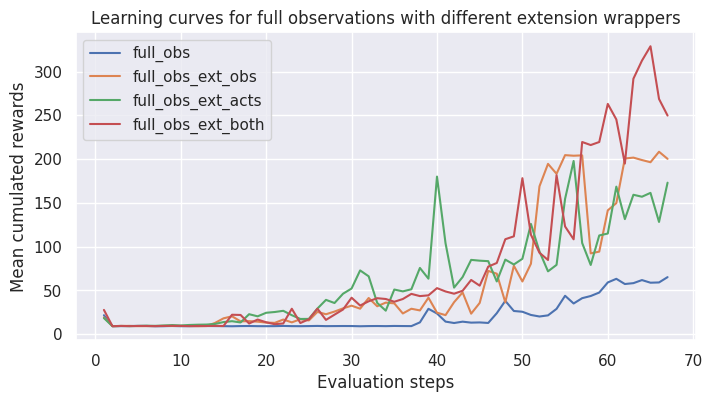

In [23]:
plot_eval_rewards(dict(list(eval_rewards.items())[:4]), 
                  title='Learning curves for full observations with different extension wrappers')

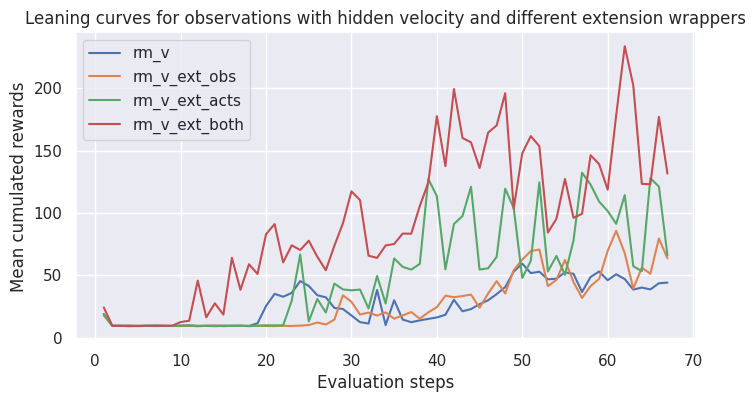

In [24]:
plot_eval_rewards(dict(list(eval_rewards.items())[4:8]), 
                  title='Leaning curves for observations with hidden velocity and different extension wrappers')

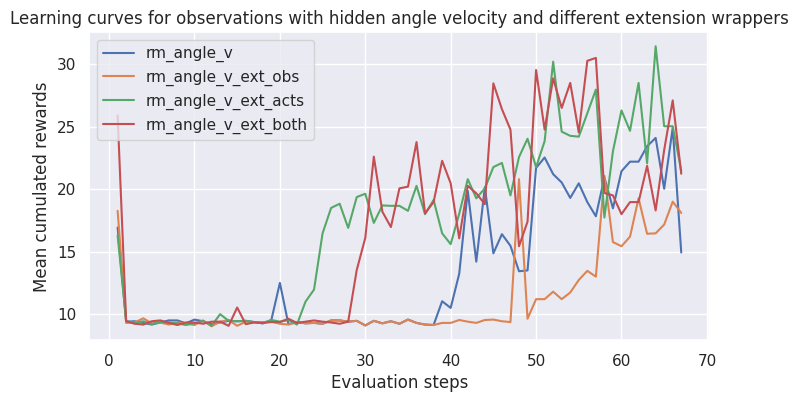

In [25]:
plot_eval_rewards(dict(list(eval_rewards.items())[8:12]), 
                  title='Learning curves for observations with hidden angle velocity and different extension wrappers')

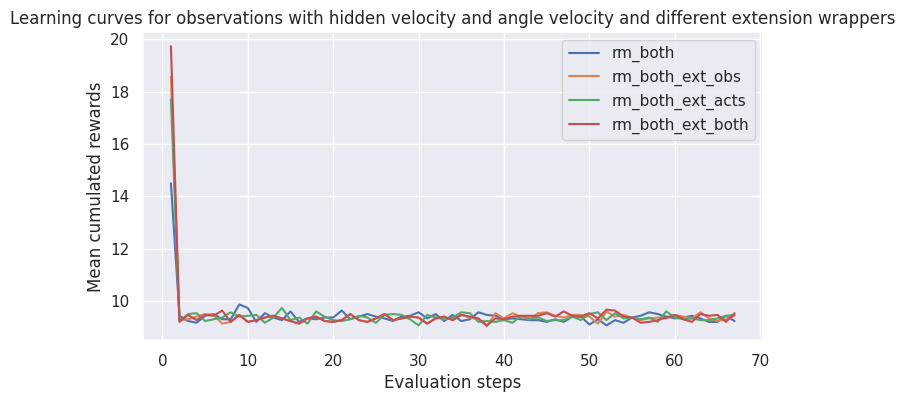

In [26]:
plot_eval_rewards(dict(list(eval_rewards.items())[12:16]), 
                  title='Learning curves for observations with hidden velocity and angle velocity and different extension wrappers')

## Extension

In this part, we study the impact of the temporal horizon for action sequences on learning performance. We consider the original `CartPoleContinuous-v1` environment with the action space extended to different sizes.

In [29]:
act_wrappers = {
    'ext_2_acts': [lambda x: ActionTimeExtensionWrapper(x, 2)],
    'ext_3_acts': [lambda x: ActionTimeExtensionWrapper(x, 3)],
    'ext_4_acts': [lambda x: ActionTimeExtensionWrapper(x, 4)],
}

eval_acts = {
    'ext_2_acts': [],
    'ext_3_acts': [],
    'ext_4_acts': [],
}

In [30]:
for seed in seeds:
    for wrapper_name, wrapper in act_wrappers.items():
        params_cfg = OmegaConf.create(params)
        params_cfg.algorithm.seed = seed 
        params_cfg.base_dir = params_cfg.base_dir + '_' + wrapper_name 
        ddpg = DDPG(OmegaConf.create(params_cfg), env_wrappers=wrapper)
        run_ddpg(ddpg)
        rewards = torch.stack(ddpg.eval_rewards)
        eval_acts[wrapper_name].append(rewards)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [31]:
for wrapper_name, rewards in eval_acts.items():
    r = torch.stack(rewards, dim=1) 
    r = r.reshape(r.shape[0], -1).detach().cpu().numpy()
    r = np.mean(r, axis=1) 
    eval_acts[wrapper_name] = r

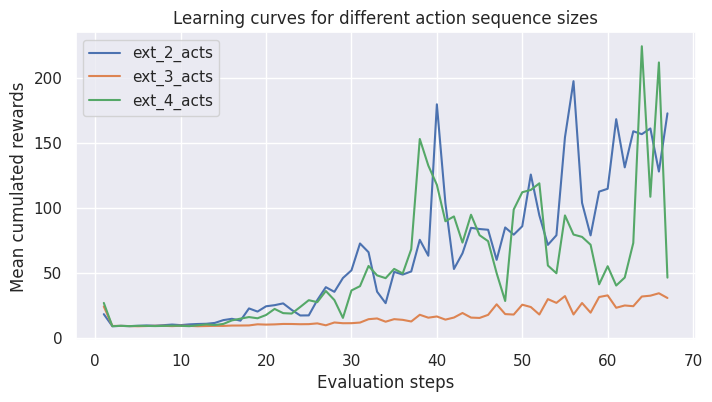

In [32]:
plot_eval_rewards(eval_acts, title='Learning curves for different action sequence sizes')

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of all the choices you have made: the parameters you have set, the algorithms you have used, etc.,
    + the curves obtained when doing Exercise 3,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can extend the temporal horizon for the state memory and or action sequences beyond 2, and study the 
impact on learning performance and training time,
you can play with other partially observable environments, etc.
A great achievement would be to perform a comparison with the approach based on an LSTM.